# Trying SLSQP on regression tests

Compared to VMCON, what converges, what doesn't? Run the regression tests using SLSQP, and analyse the results.

In [1]:
from plot_solvers import run_regression_input, compare_regression_test, plot_mfile_solutions
import pytest
from pathlib import Path
import process
from junitparser import JUnitXml
import re
import pandas as pd
import matplotlib.pyplot as plt

# Should reload Process each time (keep editable install up-to-date)
%load_ext autoreload
%aimport process, plot_solvers
%autoreload 1

PROCESS_DIR = (
    Path(process.__file__).parent.parent.resolve()
)

In [5]:
# Run pytest regression tests using SLSQP
# Produce a junitXML file to parse results
retcode = pytest.main([PROCESS_DIR, "-k", "regression", "-v", "--solver=nlopt", "--opt-params-only", "-n", "auto", "--junitxml=test_results.xml"])

============================= test session starts ==============================
platform linux -- Python 3.10.9, pytest-7.2.1, pluggy-1.0.0 -- /home/jon/anaconda3/envs/process/bin/python
cachedir: .pytest_cache
rootdir: /home/jon/code/nlopt-test-2
plugins: xdist-3.2.0, cov-4.0.0, anyio-3.6.2
gw0 I / gw1 I / gw2 I / gw3 I
[gw0] linux Python 3.10.9 cwd: /home/jon/code/notebooks/nlopt_process
[gw1] linux Python 3.10.9 cwd: /home/jon/code/notebooks/nlopt_process
[gw2] linux Python 3.10.9 cwd: /home/jon/code/notebooks/nlopt_process
[gw3] linux Python 3.10.9 cwd: /home/jon/code/notebooks/nlopt_process
[gw0] Python 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
[gw1] Python 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
[gw2] Python 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
[gw3] Python 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
gw0 [25] / gw1 [25] / gw2 [25] / gw3 [25]

scheduling tests via LoadScheduling

../../nlopt-test-2/tests/regression/test_scenarios.py::test_scen

In [63]:
# Parse the junitXML file
xml = JUnitXml.fromfile("test_results.xml")
test_results = []
for suite in xml:
    for case in suite:
        test_name = re.search(r"\[(.*)\]", case.name).group(1)
        msg = case.result[0].message
        msg_headline = msg.split("\n")[0]
        test_results.append((test_name, msg_headline))

# Create dataframe of interpreted regression test results
df = pd.DataFrame(test_results, columns=["test name", "message"])

def get_meaning(msg):
    """Interpret pytest message into simple test result."""
    if "AssertionError" in msg:
        meaning = "Converged, different"
    elif "RuntimeError" in msg:
        meaning = "Didn't converge"
    elif "failed on setup" in msg:
        meaning = "Crashed"
    elif "IFE" in msg:
        meaning = "Skipped"
    else:
        meaning = "Unknown"

    return meaning

df["meaning"] = df["message"].apply(get_meaning)
df

,test name,message,meaning
0,Bucked_and_wedged,AssertionError: assert 18 == 0,"Converged, different"
1,CFETR_small,AssertionError: assert 34 == 0,"Converged, different"
2,2D_scan,AssertionError: assert 27 == 0,"Converged, different"
3,baseline_jan_2017,AssertionError: assert 6 == 0,"Converged, different"
4,cs_fatigue_and_hts_REBCO,AssertionError: assert 30 == 0,"Converged, different"
5,G-L_Nb-Ti,"failed on setup with ""worker 'gw3' crashed whi...",Crashed
6,FNSF,RuntimeError: scipy failed to converge,Didn't converge
7,Hybrid_mode,RuntimeError: scipy failed to converge,Didn't converge
8,IFE,IFE currently uses the hybrd non-optimising so...,Skipped
9,ITER,RuntimeError: scipy failed to converge,Didn't converge


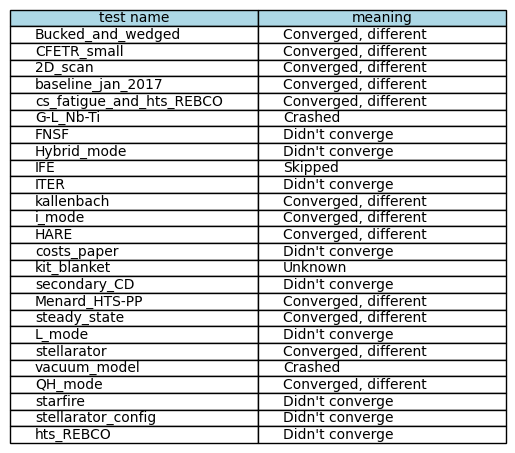

In [64]:
meaning_df = df[["test name", "meaning"]]

# Plot matplotlib table
fig, ax = plt.subplots()
ax.axis("off")
table = ax.table(cellText=meaning_df.values, colLabels=meaning_df.columns, loc="center", cellLoc="left", colColours=["lightblue", "lightblue"])

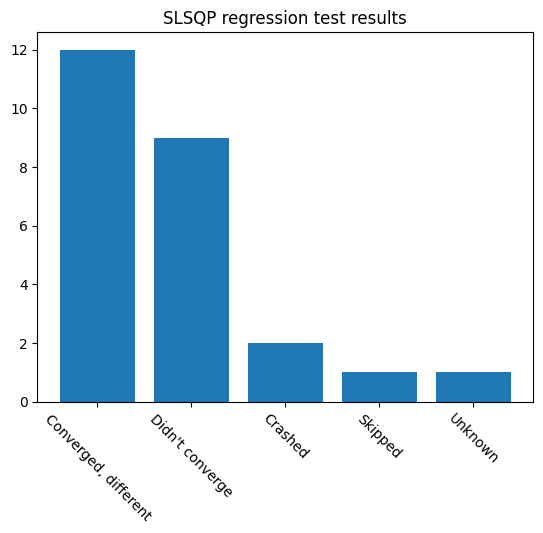

In [79]:
# Plot bar graph
meaning_freq = meaning_df["meaning"].value_counts()
fig, ax = plt.subplots()
ax.bar(meaning_freq.index, meaning_freq.values)
ax.set_title("SLSQP regression test results")
ax.tick_params("x", labelrotation=315)


### Conclusion

SLSQP converges for roughly half of the regression tests, but either doesn't converge or fails in others. Whilst the failed tests can be investigated (and possibly made to converge), how different are the converging tests from the reference cases?

## SLSQP regression solutions differences

/home/jon/code/notebooks/nlopt_process/plot_solvers.py:494: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(opt_params_labels)
/home/jon/code/notebooks/nlopt_process/plot_solvers.py:515: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(norm_objf_label)


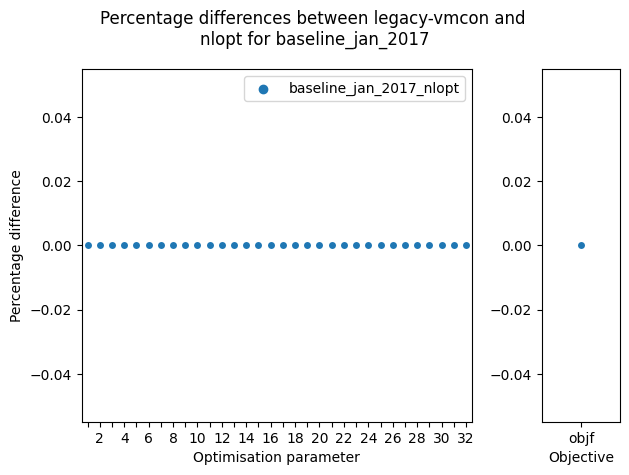

In [4]:
# Compare the baseline regression test for VMCON and SLSQP and generate 
# percentage differences in the solutions
baseline_diffs = compare_regression_test("baseline_jan_2017", ["legacy-vmcon", "nlopt"], rerun_tests=False)

Scipy's SLSQP produces a slightly different solution to VMCON, but the difference is very minor. As further examples, i_mode and QH_mode are selected from the list of converging test cases and plotted.

/home/jon/code/notebooks/nlopt_process/plot_solvers.py:494: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(opt_params_labels)
/home/jon/code/notebooks/nlopt_process/plot_solvers.py:515: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(norm_objf_label)


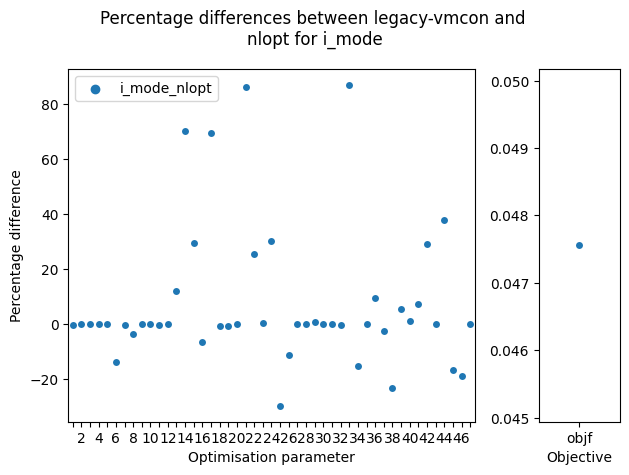

In [11]:
# Compare the i_mode regression test for VMCON and SLSQP and generate 
# percentage differences in the solutions
i_mode_diffs = compare_regression_test("i_mode", ["legacy-vmcon", "nlopt"], rerun_tests=False)

/home/jon/code/notebooks/nlopt_process/plot_solvers.py:494: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(opt_params_labels)
/home/jon/code/notebooks/nlopt_process/plot_solvers.py:515: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(norm_objf_label)


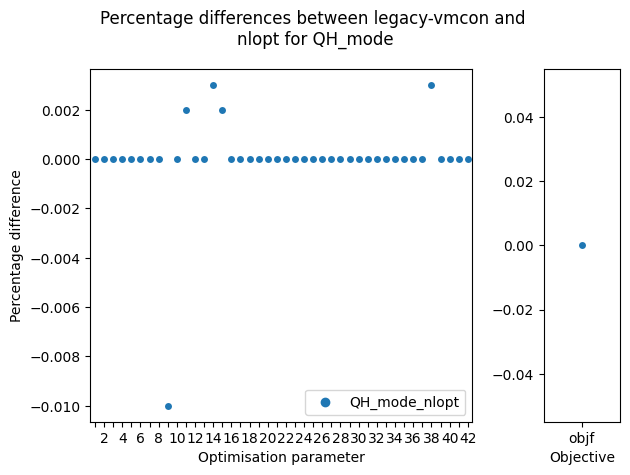

In [12]:
# Compare the QH_mode regression test for VMCON and SLSQP and generate 
# percentage differences in the solutions
qh_mode_diffs = compare_regression_test("QH_mode", ["legacy-vmcon", "nlopt"], rerun_tests=False)

i_mode shows a marked difference from the VMCON solution, and QH_mode to a lesser extent.